# Задача

Выявить наличие инсульта у человека по его параметрам

# Подключим библиотеки и загрузим данные

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import accuracy_score 
import seaborn as sns
from sklearn. preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [2]:
url = 'healthcare-dataset-stroke-data.csv'
data = pd.read_csv(url)
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Опишем признаки


id - количественный \
gender - пол(качественный: "Male", "Female", "Other")\
age - возраст(количественный)\
hypertension - наличие гипертонии(бинарный)\
heart_disease - наличие сердечных заболеваний(бинарный)\
ever_married - был ли человек когда-либо в браке(бинарный) \
work_type - тип занятости(качественный: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed")\
Residence_type - тип места жительства(качественный: Rural, Urban)\
avg_glucose_level - средний урвоень глюкозы в крови(количественный)\
bmi - индекс массы тела(количественный)\
smoking_status - информация о курении(качественный:"formerly smoked", "never smoked", "smokes" or "Unknown")      
sroke - наличие инсульта(бинарный)

# Обработаем пропущенные значения

In [3]:
missed_data = data.isnull()
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Видим, что только у признака bmi имеются пропущенные значения. Заменим их медианой:

In [4]:
data['bmi'] = data['bmi'].fillna(data['bmi'].median(axis=0), axis=0)
data.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [5]:
data[data['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Заметим, что мы имеем всего одну строчку, которая имеет значение "Other" признака "gender", поэтому мы можем просто удалить эту строчку и считать признак бинарным:

In [6]:
data = data.drop(data[data['gender'] == 'Other'].index)
data[data['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


# Борьба с выбросами

Построим матрицу диаграмм рассеивания:


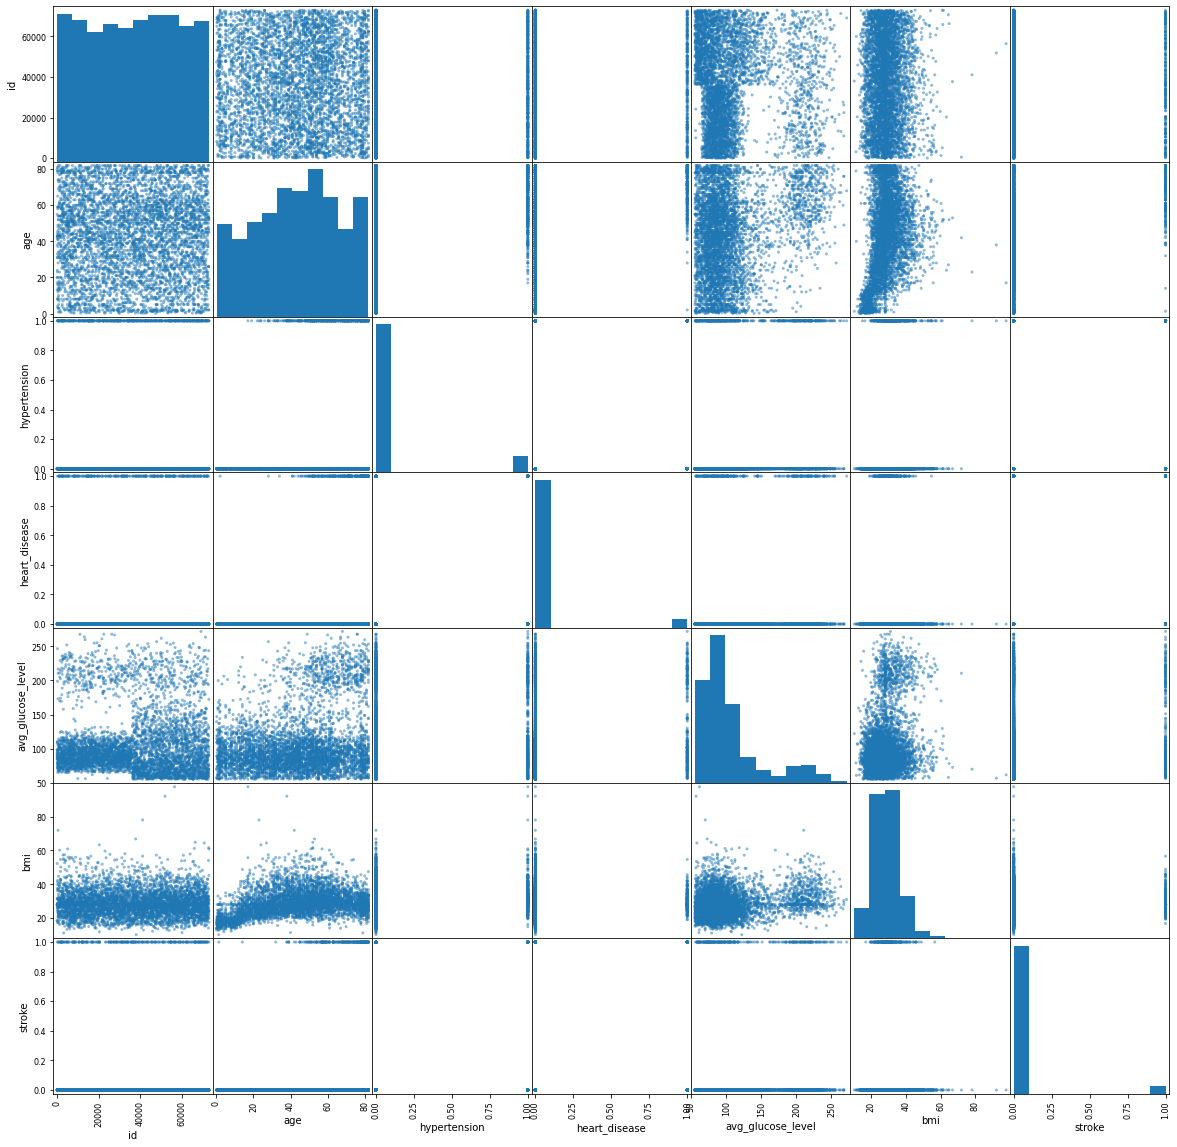

In [7]:
pd.plotting.scatter_matrix(data, figsize = (20, 20))
pass

Так же построим распределение по квантилям:

In [8]:
data.quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0.005,354.54,0.64,0.0,0.0,55.7854,14.254,0.0
0.010,724.24,1.08,0.0,0.0,56.3308,15.108,0.0
0.050,3590.40,5.00,0.0,0.0,60.7120,17.700,0.0
0.100,6972.00,11.00,0.0,0.0,65.7880,19.880,0.0
0.500,36922.00,45.00,0.0,0.0,91.8800,28.100,0.0
0.900,65668.20,75.00,0.0,0.0,192.2020,38.700,0.0
0.950,69218.40,79.00,1.0,1.0,216.3040,42.660,0.0
0.990,72265.04,82.00,1.0,1.0,240.7084,52.892,1.0
0.995,72535.12,82.00,1.0,1.0,249.2992,55.900,1.0


In [9]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,36513.985516,43.229986,0.097475,0.054022,106.140399,28.863300,0.048738
std,21162.008804,22.613575,0.296633,0.226084,45.285004,7.699785,0.215340
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17740.000000,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,36922.000000,45.000000,0.000000,0.000000,91.880000,28.100000,0.000000
75%,54643.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


По графикам можно заметить, что в численных признаках age, avg_glucose_level и bmi довольно много выбросов. Например, 99% значений признака age находится в диапазоне [0.64, 82], но значение минимальных(максимальных) экземпляров сильно отличается


Поэтому удалим все строки, в которых эти численные признаки выходят за предеры крайних квантилей:

In [10]:
rows_to_drop = data[
    (data['age'] < data['age'].quantile(0.005)) | (data['age'] > data['age'].quantile(0.995)) | 
    (data['avg_glucose_level'] < data['avg_glucose_level'].quantile(0.005)) | 
    (data['avg_glucose_level'] > data['avg_glucose_level'].quantile(0.995)) |
    (data['bmi'] < data['bmi'].quantile(0.005)) | (data['bmi'] > data['bmi'].quantile(0.995))].index
data = data.drop(rows_to_drop)

# Коррелированные признаки

Построим корелляционную матрицу:

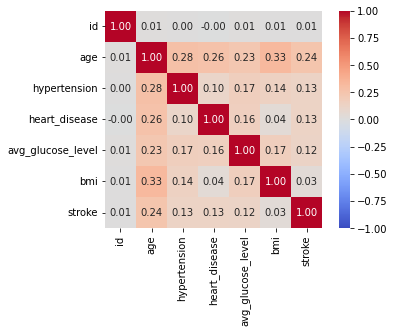

In [11]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
pass

Больших значений тут нет, поэтому удалять признаки не будем

Разобьем данные:

In [12]:
X = data.drop(['id', 'stroke', 'bmi'], axis=1)
y = data['stroke']

# Обработка качественных признаков

Заменим значения в бинарных признаках на 0 и 1:

In [13]:
X['gender'] = X['gender'].apply(lambda x: 0 if x == 'Male' else 1)
X['ever_married'] = X['ever_married'].apply(lambda x: 0 if x == 'Yes' else 1)
X['Residence_type'] = X['Residence_type'].apply(lambda x: 0 if x == 'Rural' else 1)
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status
0,0,67.0,0,1,0,Private,1,228.69,formerly smoked
1,1,61.0,0,0,0,Self-employed,0,202.21,never smoked
2,0,80.0,0,1,0,Private,0,105.92,never smoked
3,1,49.0,0,0,0,Private,1,171.23,smokes
4,1,79.0,1,0,0,Self-employed,0,174.12,never smoked
...,...,...,...,...,...,...,...,...,...
5105,1,80.0,1,0,0,Private,1,83.75,never smoked
5106,1,81.0,0,0,0,Self-employed,1,125.20,never smoked
5107,1,35.0,0,0,0,Self-employed,0,82.99,never smoked
5108,0,51.0,0,0,0,Private,0,166.29,formerly smoked


Для небинарных признаков применим OneHotEncoder, чтобы разделить эти качественные признаки на несколько бинарных:

In [14]:
X['smoking_status'] = X['smoking_status'].astype('category')
X['work_type'] = X['work_type'].astype('category')
X['smoking_status'].dtype

CategoricalDtype(categories=['Unknown', 'formerly smoked', 'never smoked', 'smokes'], ordered=False)

In [15]:
encoder = OneHotEncoder(drop='if_binary', sparse=False)
encoder.fit(X[['work_type', 'smoking_status']])
pass

In [16]:
new_data = pd.DataFrame(encoder.transform(X[['work_type', 'smoking_status']]),
                       columns=encoder.get_feature_names_out(), index=X.index)
X = pd.concat((X, new_data), axis=1).drop(['work_type', 'smoking_status'], axis=1)
X

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,67.0,0,1,0,1,228.69,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,61.0,0,0,0,0,202.21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0,80.0,0,1,0,0,105.92,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,49.0,0,0,0,1,171.23,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,79.0,1,0,0,0,174.12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,80.0,1,0,0,1,83.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5106,1,81.0,0,0,0,1,125.20,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5107,1,35.0,0,0,0,0,82.99,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0,51.0,0,0,0,0,166.29,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Масштабирование данных и балансировка

In [17]:
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)
sm = SMOTE(random_state=42, k_neighbors=5)
X, y = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34)

# Обучение модели

# Логистическая регрессия

In [18]:
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_train_predict = log_reg.predict(X_train)
y_test_predict = log_reg.predict(X_test)


print('Accuracy train: ', accuracy_score(y_train, y_train_predict))
print('Accuracy test: ', accuracy_score(y_test, y_test_predict))

Accuracy train:  0.7899412739045325
Accuracy test:  0.7832806462943449


# Случайный лес

In [19]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_train_predict = random_forest.predict(X_train)
y_test_predict = random_forest.predict(X_test)


print('Accuracy train: ', accuracy_score(y_train, y_train_predict))
print('Accuracy test: ', accuracy_score(y_test, y_test_predict))

Accuracy train:  1.0
Accuracy test:  0.9343168247277837


# K-ближайших соседей

In [20]:
from sklearn.neighbors import KNeighborsClassifier

k_neighbors = KNeighborsClassifier()
k_neighbors.fit(X_train, y_train)
y_train_predict = k_neighbors.predict(X_train)
y_test_predict = k_neighbors.predict(X_test)

print('Accuracy train: ', accuracy_score(y_train, y_train_predict))
print('Accuracy test: ', accuracy_score(y_test, y_test_predict))

Accuracy train:  0.923806655624153
Accuracy test:  0.9002458728486126


Как можно видеть, случайный лес показал наибольшую эффективность по сравнению с другими методами

# Изменение гиперпараметров

In [21]:
from sklearn.model_selection import GridSearchCV

count_estimators = [i for i in range(50, 1001, 50)]
params = {"n_estimators": count_estimators}
random_forest = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, scoring="accuracy")
random_forest.fit(X_train, y_train)

random_forest.best_score_, random_forest.best_params_

(0.9286264697616652, {'n_estimators': 1000})

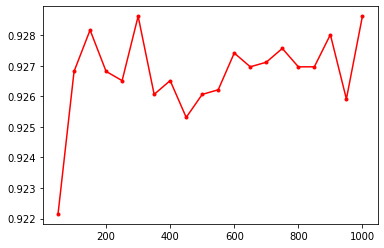

In [22]:
import matplotlib.pyplot as plt

accuracy = random_forest.cv_results_['mean_test_score']
plt.plot(count_estimators, accuracy, 'r.-')

Обновим гиперпараметры:

In [23]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=550)
random_forest.fit(X_train, y_train)
y_train_predict = random_forest.predict(X_train)
y_test_predict = random_forest.predict(X_test)


print('Accuracy train: ', accuracy_score(y_train, y_train_predict))
print('Accuracy test: ', accuracy_score(y_test, y_test_predict))

Accuracy train:  1.0
Accuracy test:  0.9339655778011943


# Вывод

В итоге мы получили довольно точный классификатор наличия инсульта у человека. В ходе работы были применены такие методы, как k-ближайших соседей, логистическая регрессия и случайный лес. Наилучший результат показал случайный лес - 0.937. k-ближайших соседей тоже показал хороший результат - 0.92, логистическая регрессия же показала результат значительно хуже - всего лишь 0.79